In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator


In [6]:
trainData = ImageDataGenerator()
trainingdt = trainData.flow_from_directory(directory='RealvsFake/Training', target_size=(224,224))


Found 101965 images belonging to 2 classes.


In [7]:
testData = ImageDataGenerator()
testingdt = testData.flow_from_directory(directory='RealvsFake/Testing', target_size=(224,224))


Found 20076 images belonging to 2 classes.


In [8]:
def preprocess(file_path):
        byte_img = tf.io.read_file(file_path)
        img = tf.io.decode_jpeg(byte_img)
        img = tf.image.resize(img, (224,224))
        img = img / 255.0
        return img

In [9]:
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(224,224,3),
                   pooling='max',classes=2,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)

In [10]:
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(2, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation
             ='elu'))

In [11]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 24,900,482
Trainable params: 1,312,770
Non-trainable params: 23,587,712
_________________________________________________________________


In [9]:
resnet_model.compile(optimizer=Adam(lr=3e-4),loss='hinge',metrics=['accuracy'])

history = resnet_model.fit(trainingdt, validation_data=testingdt, epochs=10, steps_per_epoch=100, validation_steps=10)

C:\Users\viola\anaconda3\envs\keras_env\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
100/100 [==============================] - 349s 3s/step - loss: 1.0624 - accuracy: 0.4950 - val_loss: 1.0323 - val_accuracy: 0.4875
Epoch 2/10
100/100 [==============================] - 373s 4s/step - loss: 1.0300 - accuracy: 0.4997 - val_loss: 1.0279 - val_accuracy: 0.5437
Epoch 3/10
100/100 [==============================] - 377s 4s/step - loss: 1.0263 - accuracy: 0.5066 - val_loss: 1.0248 - val_accuracy: 0.4906
Epoch 4/10
100/100 [==============================] - 377s 4s/step - loss: 1.0236 - accuracy: 0.4988 - val_loss: 1.0224 - val_accuracy: 0.4906
Epoch 5/10
100/100 [==============================] - 378s 4s/step - loss: 1.0213 - accuracy: 0.5066 - val_loss: 1.0203 - val_accuracy: 0.4656
Epoch 6/10
100/100 [==============================] - 378s 4s/step - loss: 1.0194 - accuracy: 0.5094 - val_loss: 1.0185 - val_accuracy: 0.5031
Epoch 7/10
100/100 [==============================] - 356s 4s/step - loss: 1.0177 - accuracy: 0.4956 - val_loss: 1.0169 - val_accuracy: 0.5063

In [10]:
resnet_model.save('resnet50SVMelu.h5')

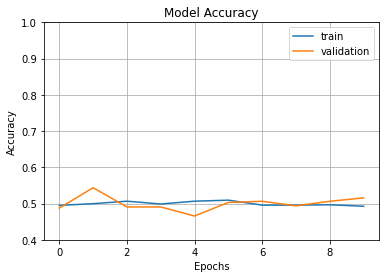

In [11]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

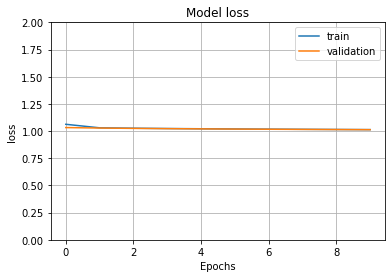

In [15]:
fig1 = plt.gcf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.axis(ymin=0,ymax=2)
plt.grid()
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [16]:
from keras.models import load_model
y_actual= testingdt.labels
resnet_model1= load_model("resnet50SVMelu.h5")
pred= resnet_model.predict(testingdt, batch_size=32)
pred= np.argmax(pred, axis=-1)
from sklearn.metrics import classification_report
print(classification_report(pred, y_actual, target_names=['fake(class0)', 'real(class1)']))

              precision    recall  f1-score   support

fake(class0)       0.15      0.50      0.24      3094
real(class1)       0.85      0.50      0.63     16982

    accuracy                           0.50     20076
   macro avg       0.50      0.50      0.43     20076
weighted avg       0.74      0.50      0.57     20076



In [17]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
predictions = resnet_model.predict(testingdt)
predictions = np.argmax(predictions, axis=1)
true_classes = testingdt.labels
report = classification_report(true_classes, predictions, target_names=['fake', 'real'])
print(report)   
cm=confusion_matrix(true_classes,predictions)
print(cm)

              precision    recall  f1-score   support

        fake       0.50      0.15      0.23     10030
        real       0.50      0.85      0.63     10046

    accuracy                           0.50     20076
   macro avg       0.50      0.50      0.43     20076
weighted avg       0.50      0.50      0.43     20076

[[1538 8492]
 [1556 8490]]


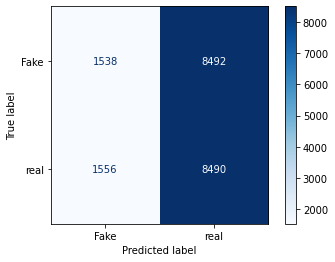

In [19]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
labels = ["Fake", "real"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()